# Xplique : A Deep Learning Explainability toolbox.

## [1] Xplique
A Deep Learning Explainability Toolbox
Thomas Fel Lucas Hervier
David Vigouroux Antonin Poche
Justin Plakoo Remi Cadene Mathieu Chalvidal
Julien Colin Thibaut Boissin Louis Bethune Agustin Picard Claire Nicodeme
Laurent Gardes Gregory Flandin Thomas Serre


1 er lien initial du prof : https://arxiv.org/pdf/2206.04394
Article de 2 pages présentant Xplique : 
- Intro : expliquation que ajd les réseaux de neuronnes ont besoin d'expliquabilité parce que c'est trop des black-box. Xplique est une librairie principalement utilisé pour Tensorflow.

Je crois que ce notebook à porté d'explorer l'explicabilité locale et non globale. Donc on va checher pour une input donnée à determiner pourquoi notre modèle à fait cette prédiction. Contrairement à une feature importance ou on va voir les features les plus importantes.

3 méthodes pour faire de l'explicabilité : 
- Attribution methodes : They elucidate specific model predictions by computing the most critical data features used by the model. Pour une image c'est assez parlant. On vient exhiber les features qui ont le plus contribuer à la décision du modèle. On utilise plusieurs modèles d'explicabilté (plus de 14 modèles de représentation). Ces modèles sont listés dans l'article section 1.1 Attribution methods. 

- Feature Visualisation : Generates a new data samples aiming to be the most representative of a particular propriety (ex : a class). On va étudier le réseau de neuronne en lui même (donc les hidden layer) et créant des inputs qui vont faire target des neuronnes, groupes de neuronnes ou direction dans l'espace du réseau. "This method aims to find an interpretable input (or stimulus) that maximizes the response of a given neuron, a set of neurons (e.g., a channel) or a direction in an internal space of
the model"

- Concept-based Methods : Automatically extract concepts learned by the model and evaluate there importance for each prediction. Je comprend pas trop : je met cette article en attente : https://proceedings.mlr.press/v80/kim18d/kim18d.pdf 


<img src="images/3methodes.png">


- Lien du site DEEL : https://www.deel.ai/explainability/


- Il y a les modèles d'explicabilité d'un côté et aussi les éléments de métriques pour comparer les différentes méthodes d'explicabilité.


## idées générales sur la présentation du notebook
On peut présenter : 
- se concentrer sur une des méthodes et l'explorer jusqu'au bout
- On peut un peu tout présenter

## Le github de Xplique https://github.com/deel-ai/xplique
J'utilise tensorflow v 2.15
J'utilise le requirement.txt
Python 3.11.2
env cryptoenv 
enft c'est une librairie donc on l'installe avec pip install

# Attributions Methods

Xplique implémente uniquement des méthodes déjà existante de modèle : https://deel-ai.github.io/xplique/latest/api/attributions/api_attributions/ 

"  Methods
Even though we made an harmonized API for all attributions methods, it might be relevant for the user to distinguish Perturbation-based methods and Gradient-based methods, also often referenced respectively as black-box and white-box methods, as their hyperparameters settings might be quite different. " 

## Perturbation-based approaches
- on fait varier les inputs selon un modèle et on regarde la sortie
- Pas besoin que ça soit un réseau de neuronne, marche aussi avec d'autre algo de ML
- Notament pas besoin de connaître la structure du réseau de neuronne
- On utilise aussi le terme de black box
- on a vu en cours Shap (ici ils ont implémenté KernelShap) et Lime 

Leur liste de Perturbation-based approaches : 
- KernelShap
- Lime
- Occlusion
- Rise 
- Sobol Attribution
- Hsic Attribution 

## Gradient-based approaches
- requière un accès complet à l'architecture et utilise les gradiants calculé lors de la desentes de gradient.
- Ne s'applique que aux algorithme qui utilise la backpropagation, donc les réseau de neuronne. 
- va utiliser la backpropagation pas pour update les poids mais pour voir ceux qui contribu le plus.

Leur list de Gradient-based approaches : 
- DeconvNet
- GradCAM
- GradCAM++
- GradientInput
- GuidedBackpropagation
- IntegratedGradients
- Saliency
- SmoothGrad
- SquareGrad
- VarGrad 

## Description de l'API

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from math import ceil
import cv2

import xplique
from xplique.plots import plot_attributions



[('./data/fox1.jpg', 277), ('./data/fox2.jpg', 277), ('./data/sea_turtle.jpg', 33), ('./data/lynx.jpg', 287), ('./data/cat.jpg', 281), ('./data/otter.jpg', 360)]


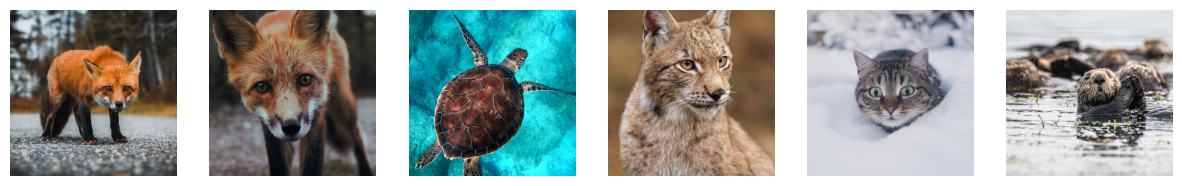

In [ ]:
# downloading image from unsplash...
# !wget -nv 'https://unsplash.com/photos/X2PwqTUpXH8/download?force=true&w=640' -O 'fox1.jpg'
# !wget -nv 'https://unsplash.com/photos/tIfrzHxhPYQ/download?force=true&w=640' -O 'fox2.jpg'
# !wget -nv 'https://unsplash.com/photos/LVnJlyfa7Zk/download?force=true&w=640' -O 'sea_turtle.jpg'
# !wget -nv 'https://unsplash.com/photos/sSEEbAzB6fU/download?force=true&w=640' -O 'lynx.jpg'
# !wget -nv 'https://unsplash.com/photos/41dAczoRYJY/download?force=true&w=640' -O 'cat.jpg'
# !wget -nv 'https://unsplash.com/photos/axqTLZ12Jss/download?force=true&w=640' -O 'otter.jpg'

img_list = [
    ('fox1.jpg', 277),
    ('fox2.jpg', 277),
    ('sea_turtle.jpg', 33),
    ('lynx.jpg', 287),
    ('cat.jpg', 281),
    ('otter.jpg', 360)
]


img_list = [("./data/" + e[0],e[1]) for e in img_list]

def central_crop_and_resize(img, size=224):
  """
  Given a numpy array, extracts the largest possible square and resizes it to
  the requested size
  On va utiliser MobileNetV2 pour classifier nos images et ce réseau de neuronne prend en entrée des images de taille 
  (224, 224, 3)
  """
  h, w, _ = img.shape

  min_side = min(h, w)
  max_side_center = max(h, w) // 2.0

  min_cut = int(max_side_center-min_side//2)
  max_cut = int(max_side_center+min_side//2)

  img = img[:, min_cut:max_cut] if w > h else img[min_cut:max_cut]
  img = tf.image.resize(img, (size, size))

  return img

X = []
Y = []

for img_name, label in img_list:
    img = cv2.imread(img_name)[..., ::-1] # when cv2 load an image, the channels are inversed
    img = central_crop_and_resize(img)
    label = tf.keras.utils.to_categorical(label, 1000)

    X.append(img)
    Y.append(label)

X = np.array(X, dtype=np.float32)
Y = np.array(Y)

plt.rcParams["figure.figsize"] = [15, 6]
for img_id, img in enumerate(X):
  plt.subplot(1, len(X), img_id+1)
  plt.imshow(img/255.0)
  plt.axis('off')

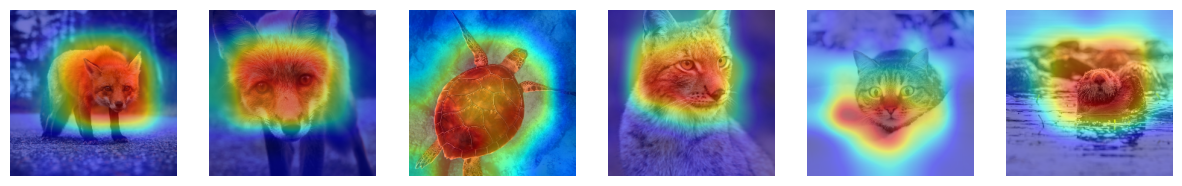

In [16]:
from xplique.attributions import GradCAM
import tensorflow.keras.applications as app

# load the model and preprocess the inputs (adapt the input range)
model, preprocessing = app.MobileNetV2(), app.mobilenet_v2.preprocess_input
X_preprocessed = preprocessing(np.array(X, copy=True))

# create an explainer and generate explanations

explainer = GradCAM(model)
explanations = explainer(X_preprocessed, Y) # `explainer.explain(inputs, labels)` also works

# plot the attribution on top of the image
for i in range(len(X)):
  plt.subplot(1, len(X), i+1)
  plt.imshow(X[i]/255.0)
  plt.imshow(explanations[i], cmap="jet", alpha=0.5)
  plt.axis('off')

/home/bolympio/miniconda3/envs/cryptoenv/lib/python3.11/site-packages/xplique/attributions/lime.py:129: UserWarning: You set a number of perturbed samples per input >= 500 and batch_size is set to NoneThis mean that you will ask your model to handle more than 500 perturbed samples per input at once.This can lead to OOM issue. To avoid it you can set the batch_size argument.
  warnings.warn(


Method: Saliency


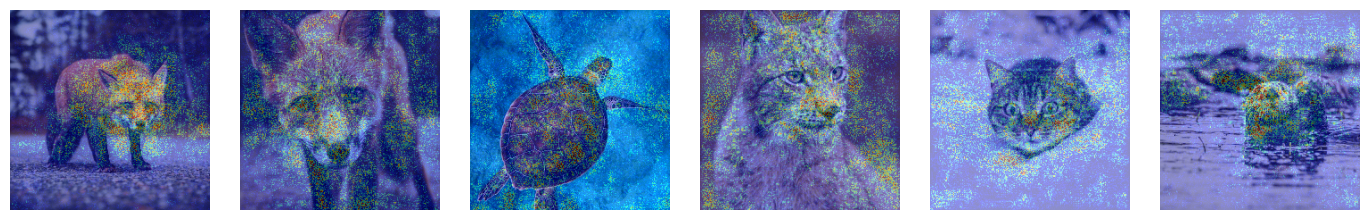



Method: GradientInput


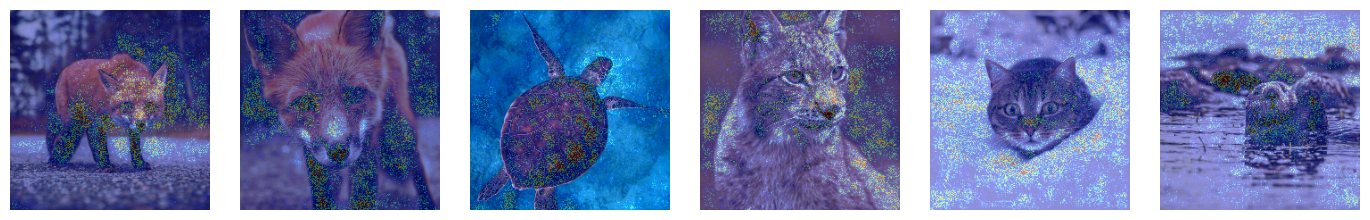



Method: GuidedBackprop


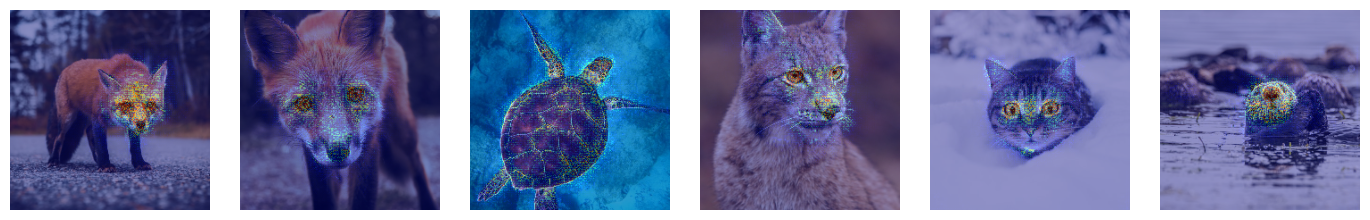



Method: IntegratedGradients


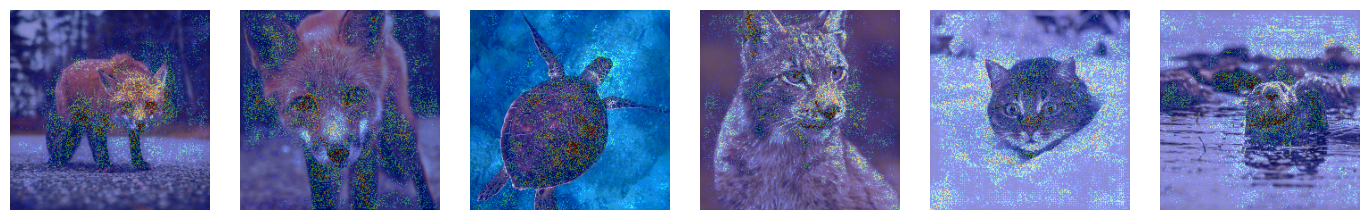



Method: SmoothGrad


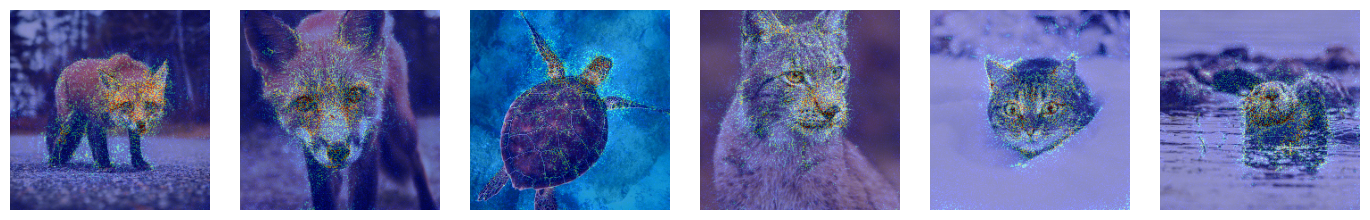



Method: SquareGrad


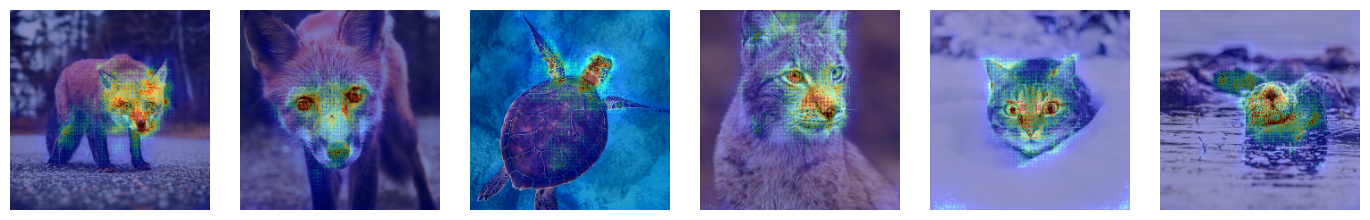



Method: VarGrad


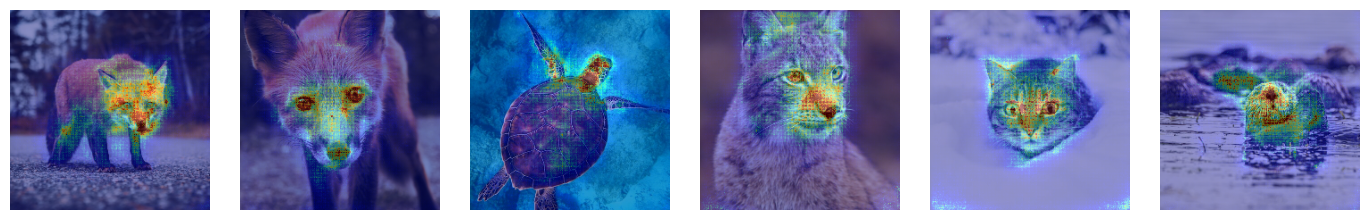



Method: GradCAM


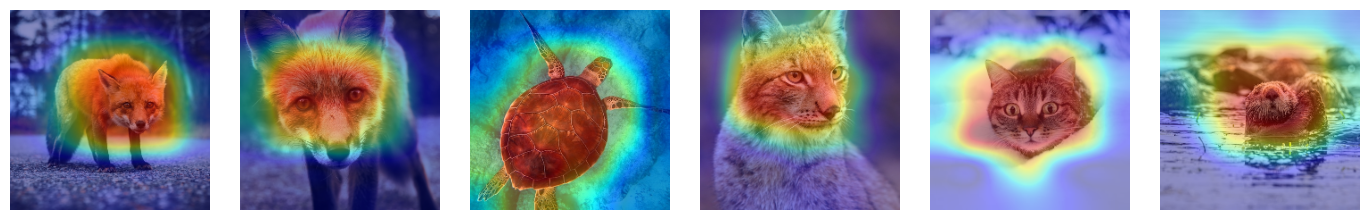



Method: GradCAMPP


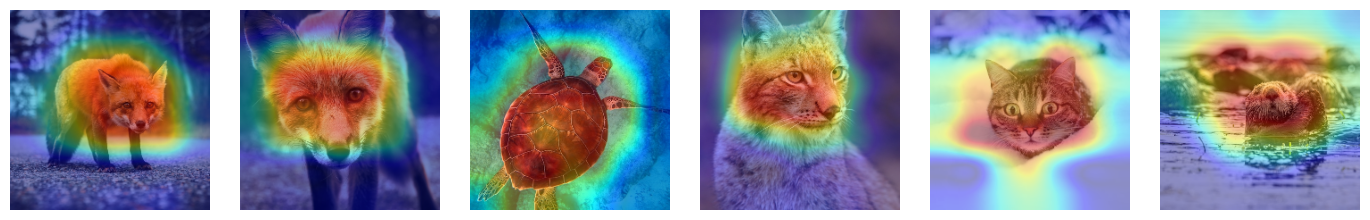



Method: Occlusion


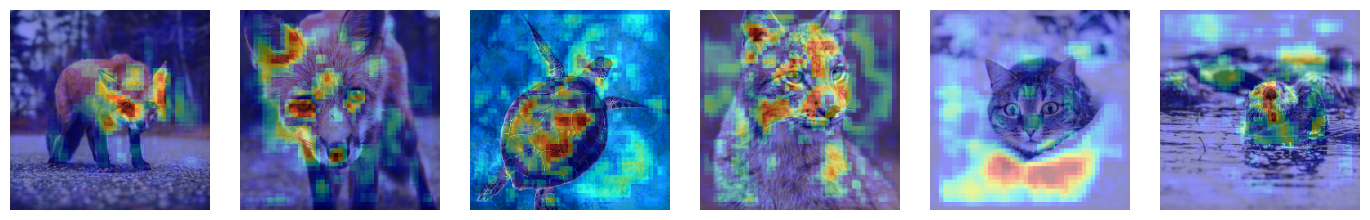

KeyboardInterrupt: 

In [17]:
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad,
                                  SquareGrad, GradCAM, Occlusion, Rise, GuidedBackprop,
                                  GradCAMPP, Lime, KernelShap, SobolAttributionMethod)

# explaining the logits is to explain the class,
# explaining the softmax is to explain why this class is more likely
# it is therefore recommended to explain the logit
model.layers[-1].activation = tf.keras.activations.linear
batch_size = 64

explainers_gradient = [
  Saliency(model),
  GradientInput(model),
  GuidedBackprop(model),
  IntegratedGradients(model, steps=80, batch_size=batch_size),
  SmoothGrad(model, nb_samples=80, batch_size=batch_size),
  SquareGrad(model, nb_samples=80, batch_size=batch_size),
  VarGrad(model, nb_samples=80, batch_size=batch_size),
  GradCAM(model),
  GradCAMPP(model)
]

explainers_perturbation = [
  Occlusion(model, patch_size=10, patch_stride=5, batch_size=batch_size),
  Rise(model, nb_samples=4000, batch_size=batch_size),
  SobolAttributionMethod(model, batch_size=batch_size),
  Lime(model, nb_samples = 1000),
  KernelShap(model, nb_samples = 1000)
]

for explainer in explainers_gradient:

  explanations = explainer(X_preprocessed, Y)

  print(f"Method: {explainer.__class__.__name__}")
  plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)
  plt.show()
  print("\n")
  
for explainer in explainers_perturbation:

  explanations = explainer(X_preprocessed, Y)

  print(f"Method: {explainer.__class__.__name__}")
  plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)
  plt.show()
  print("\n")

Donc on a eu une rapide introduction de comment on utilise l'API. Maintenant on va détaillé un peu par catégorie : 

### Perturbation-Based Method
Donc basé sur on va créer une distribution d'inputs autour d'un input0.

- Lime : va diviser les data de base en un espace d'interprétation, par exemple avec des super pixels. Puis on va choisir le nombre de super pixel que l'on garde et générer une nouvelle image (donc on a 2^num_interpretable_sample)

- KernelShap
- Lime
- Occlusion
- Rise 
- Sobol Attribution
- Hsic Attribution 

### Gradient-based apporaches
Demande un accès complet à l'architecture du réseau. On utilise la backpropagation pour pas pour actualiser les poids mais pour revéler les inputs qui contribuent le plus. 

Inutile en vrai ce que j'ai écrit 

Faut revenir sur ce qui à été ecrit pour le score

## Metric for Attributions Methods 
Donc les méthodes qu'on a vu jusuq'à présent sont appliqué pour la vision par ordinateur. En gros l'expliquabilité va nous produire quelquechose et on va avoir une heatmap sur les images qu'on a prédit. La seul métric qu'on a encore c'est de voir si les pixels sur lequels ont été fait la prédiction correspondent au même que ceux qu'aurait pointer un humain. Mais cela peut avoir les biais de l'humain.
On introduit donc 2 métric qui se base **seulement** sur les variations des probabilité que l'image appartiennent à une classe ou une autre.
Xplique présente 2 métriques qui ne sont pas les seuls.

2 type de métrics :
- ExplanationMetric : MuFidelity, Deletion and Insertion 
- ExplainerMetric : AverageStability 

Deletion Metrics : 
La methode de saliency nous donne une map des pixels les plus importants. On va voir les pixels qui ont le moins besoin d'être modifié pour changer la classe probabilité. 
Donc pour cette metrique On va retirer petit à petit les pixels les plus importants et moins on en retire, je suis pas sur de quel pixel on retire. 

# Concept Extraction

Donc l'idée de l'extraction de concept c'est de définir des concepts de haut niveau compréhensible par l'être humain visuel. On va aller voir dans les couche profonde du réseau de neuronne, qui sont représentatif des concepts de haut niveau qu'a apris le réseau. Pour cela on va split le réseau en 2, le réseau c'est la fonction f qui prend en entrée une input et qui renvoie la sortie. 
On travail avec des classifier d'image donc f(X) = o avec X une image et o la classe de cette image.
On va split le classifier en deux fonction f = h o g.
g va être la fonction qui à partir de l'image va la projeter sur cette espace latent de haut niveau de concept. Donc la sortie de g(X) ça va être l'espace latent de l'image ou on l'aura décortiquer.
La fonction h est donc la fonction qui de cette espace lattent ou les images sont décortiquer va trouver la classe de l'image. 
De cette espace latent on va extraire des concepts et en utilisant h on va prédire à qu'elle points ces concecpts sont important pour la classification de notre images. 


# Feature 


https://distill.pub/2017/feature-visualization/ Article qui explique ce que c'est la data vizualisation. 



# Metrics